# Final Project- MTA Subway Predictor

## Brian Murphy, bpm9231

The goal of this assignment was to train models to predict subway ridership.

This was split into three phases:
1.  Data Analysis and Preprocessing
2.  Data splitting and alignment
3.  Training models and comparision

### Problem definition
The MTA NYC Transit subway operates hundres of stations on a 24/7 basis. Ridership can change drastically between stations, and varies by time as well. Routes also affect ridership, with some being more used than others. As a result, predicting ridership is difficult, and machine learning could be the answer to do so.

As an Analys in the MTA, I want to know if hourly ridership can be predicted accurately with machine learning. This may help with resource allocation or strain. 

As a New Yorker, I want to know if how I feel about the system can be backed up by machine learning. I have my own ideas of good times to ride the subway to avoid crowds, and wanted to see if it could be predicted. 
### Data:  
From the NYS Data Portal: <a href="https://data.ny.gov/Transportation/MTA-Subway-Hourly-Ridership-Beginning-February-202/wujg-7c2s/about_data">MTA Subway Hourly Ridership: Beginning February 2022 | State of New York (ny.gov)</a>

- Time series dataset, containing hourly data for 425 stations
- Ridership is broken by hour, station id, and payment type
    - Station ID further links to router
- Dataset is over 2.3 GB in size, over 12 million rows
- Has 12 columns in total
### Preprocessing
- S102 SIR has 2 blank values for route, which were removed
-  Removed 6 columns:
    - Georeference, latitude, longitude-  not relevant as they should be constant
    - transfers- part of ridership field
    - Itsuid- timestamp+station_id, not needed
    - station_complex- one to one relationship with station_complex_id
    - Borough- not relevant, focus is on station
- The following columns remain:
    1. transit_timestamp- hourly timestamp with AM/PM
    2. station_complex_id- unique identifier for station
    3. Routes- 7, NRW, ACE, etc. These are the lines serviced at each complex id
    4. Payment_method- either omny or metrocard
    5. Ridership- target variable
- I also added Year, Month, Day, and Hour fields to help during training. 
- Used get_dummies to convert categorical string values into columns with 0 or 1
### Challenges:

- Dataset has string variables for most non categorical features
- Some of the earlier data (February 2022) is inconsistent, but this should be smoothed out by the rest of the dataset
- Covid-19, construction, events, closures, and other outside factors affect ridership, but were not captured in the dataset. However, the volume of data should help correct for this.

**Major issue**- data size is 2.3GB and over 12 million rows
- Subset was created using 6 months for A-C( June 2023-Nov 19 2023), over 3million rows. 

## Train and Test split
Train data was taken from the last 6 months, from June 2023 to Nov 12 2023. The last week of training data, Nov 12 to Nov 19, was used to test the models.

### Models and Training Strategies used:

1. skforecast autoreg- forecaster used with skforecast module
3. Linear regression, used only for training on the whole subset or a station

### Training Strategies:

    A- Train on entire subset
    B- Train for a specific station on subset (R533, Flushing Main street)
    C- Train for a specific station on whole dataset

get_dummies used in all scenarios to allow proper comparision of results. This exploded the columns from station_complex_id to station_complex_id_ID (e.g station_complex_id_N033).

To group by station id, I got values where the column for that id was 1. 

Compare all three using score method, and graphed predictions of the last week of data. 
### Hypothesis

Training by month will be more noisey, and produce worse results. Going by station id should be more stable overall.

### Differences from video presentation

- Error found- 
    - Findings for training by station not done using partial_fit, so removed from current report
- Additional model of skforecast AutoReg
- More RAM installed, allowing better attempts
- More training strategies used
- Changes to graphs

# Table of Contents
* [Summary](#Summary-of-Findings)
* [Data Analysis and Preprocessing](#Data-Analysis-and-Preprocessing)
* [Training-on-Last-6-Months-of-Data-and-Subset](#Training-on-Last-6-Months-of-Data-and-Subset)

In [1]:
import sys
try:
    import pydotplus
    print("PydotPlus ready")
    import skforecast
    print("skforecast ready")
except:
    !conda install --yes --prefix {sys.prefix} pydotplus
    #!conda install --yes --prefix {sys.prefix} skforecast
    !pip install skforecast
    import pydotplus
    print("PydotPlus ready")
    import skforecast
    print("skforecast ready")



PydotPlus ready
skforecast ready


# Summary of Findings

Comparing skforecast agains Linear Regression on a subset, specific station in the subset, showed linear regression to be better at prediction overall. In the graph below, Linear regression nearly matched the training set while skforecast drew a single line. 

However, when predicting R533 within the subset, linear regression fell short of the data, while skforecast was more spread out toward the middle in predictions. Looking at the station overall, skforecast again clustered toward the middle, while linear regression drew down again.

Overall, this shows to me that it is possible to train a machine learning model to predict hourly ridership. For more specific results, skforecast should be used, while linear regression can do better when the data is more spread out.

In [2]:
import numpy as np
import time
from sklearn.preprocessing import LabelEncoder
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Load dataset
urldata="C:/Users/bmurp/Downloads/MTA_Subway_Hourly_Ridership__Beginning_February_2022.csv"

df_url=pd.read_csv(urldata)
df_url['transit_timestamp']=pd.to_datetime(df_url['transit_timestamp'], format="%m/%d/%Y %I:%M:%S %p")
df_url.sort_values(by='transit_timestamp', inplace=True)
print(len(df_url))
print(df_url.dtypes)
#print(df_url.head())

12744121
transit_timestamp     datetime64[ns]
station_complex_id            object
station_complex               object
borough                       object
routes                        object
payment_method                object
ridership                      int64
transfers                      int64
latitude                     float64
longitude                    float64
Georeference                  object
itsuid                        object
dtype: object


In [4]:
# Convert the timestamp from mm/dd/yyyy hh:mm:ss AM/PM to normal datetime, and extract year,month,day,hour

df_url['Year']=df_url['transit_timestamp'].dt.year
df_url['Month']=df_url['transit_timestamp'].dt.month
df_url['Day']=df_url['transit_timestamp'].dt.day
df_url['Hour']=df_url['transit_timestamp'].dt.hour
print(len(df_url))
print(df_url.dtypes)
print(df_url['transit_timestamp'].max())
# Downloaded was taken some time ago, for more recent data comparisions use: https://data.ny.gov/resource/wujg-7c2s.json?$select=count(*)&$where=transit_timestamp%3E%272023-11-19T23:00:00.000%27

12744121
transit_timestamp     datetime64[ns]
station_complex_id            object
station_complex               object
borough                       object
routes                        object
payment_method                object
ridership                      int64
transfers                      int64
latitude                     float64
longitude                    float64
Georeference                  object
itsuid                        object
Year                           int64
Month                          int64
Day                            int64
Hour                           int64
dtype: object
2023-11-19 23:00:00


## Data Analysis and Preprocessing

Overall average hourly ridership seems to follow a trend. When looking between stations, high and low end vary wildly, while in the middle things seem more stable. However, within a station, ridership seems somewhat stable. 

There are also several columns that are not needed or redundant. Station_complex maps to station_complex_id, geodata is static, and borough shouldn't matter when predicting specific stations.

Based upon this, I removed unncessary columns, converted the transit_timestamp to a datetime, and added Year,Month,Day, and Hour fields to allow for more time features to be considered.

Average Hourly ridership overall:154.93142179048678 
Stations with largest average hourly ridership
station_complex_id  station_complex                                                              
N060                Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)/Bryant Pk (B,D,F,M)/5 Av (7)    2849.877149
R238                Grand Central-42 St (S,4,5,6,7)                                                  1563.333376
A022                34 St-Herald Sq (B,D,F,M,N,Q,R,W)                                                1285.328880
A034                14 St-Union Sq (L,N,Q,R,W,4,5,6)                                                 1143.174316
N095                Fulton St (A,C,J,Z,2,3,4,5)                                                       955.222368
Name: ridership, dtype: float64


Stations in the middle of average hourly ridership
station_complex_id  station_complex              
H006                3 Av (L)                         89.464683
N134                Rockaway Blvd (A)  

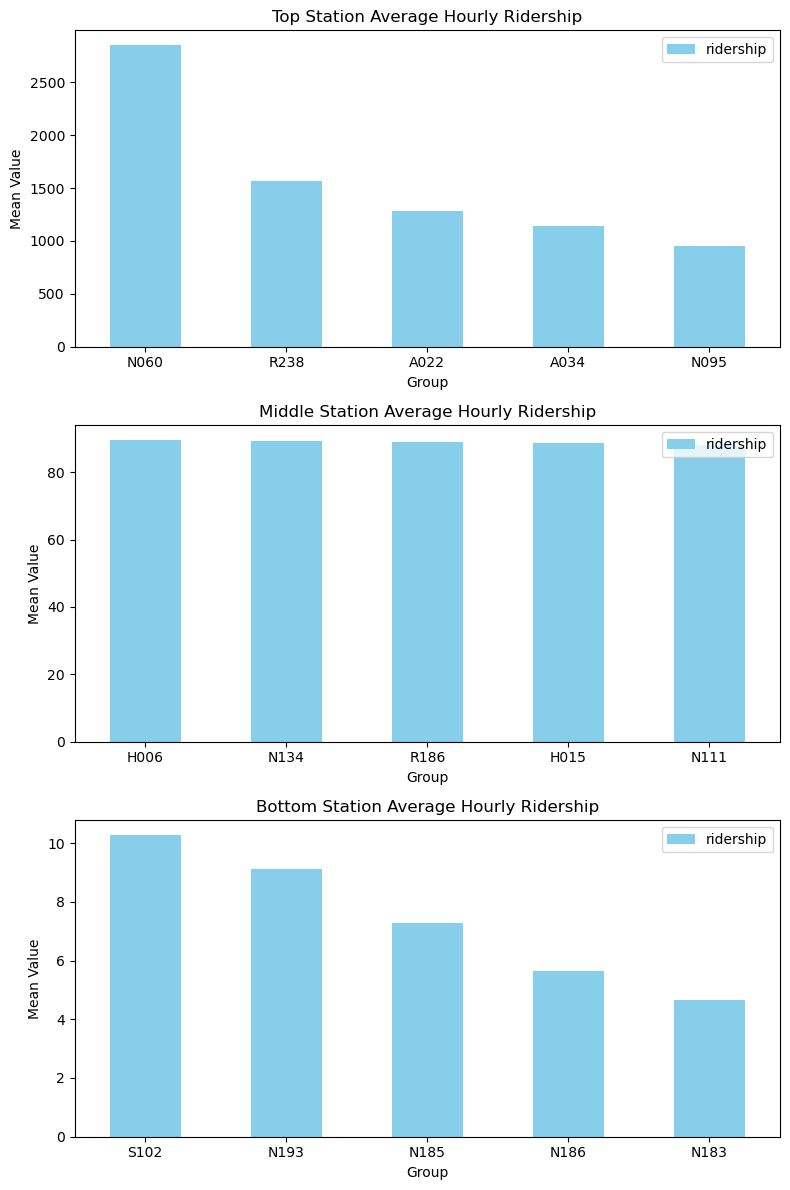

In [5]:
# Data analysis, show station average hourly ridership to see what trends can be observed.

key=['station_complex_id','station_complex']

print(f"Average Hourly ridership overall:{df_url['ridership'].mean()} ")
grouped_data=df_url.groupby( key)['ridership'].mean().sort_values(ascending=False)

middle_grouped=(len(grouped_data)-5)//2
print("Stations with largest average hourly ridership")
print(grouped_data.head())
print("\n")

print("Stations in the middle of average hourly ridership")
print(grouped_data[middle_grouped:middle_grouped+10])
print("\n")

print("Stations with lowest average hourly ridership")
print(grouped_data.tail())
print("\n")
# Pivot the data for easier plotting

grouped_data_av = df_url.groupby(['station_complex_id', 'station_complex'])['ridership'].mean().reset_index()

# Sort the data by mean ridership in descending order
grouped_data_av = grouped_data_av.sort_values(by='ridership', ascending=False)
middle_index=(len(grouped_data_av)-5)//2
# Plot the top and bottom groups based on mean ridership
top_groups = grouped_data_av.head(5)
bottom_groups = grouped_data_av.tail(5)

middle_groups = grouped_data_av[middle_index:middle_index+5]

fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(8, 12))

top_groups.plot(kind='bar', x='station_complex_id', y='ridership', rot=0, color='skyblue', ax=ax1,
                title='Top Station Average Hourly Ridership')
ax1.set_xlabel('Group')
ax1.set_ylabel('Mean Value')
middle_groups.plot(kind='bar', x='station_complex_id', y='ridership', rot=0, color='skyblue', ax=ax2,
                title='Middle Station Average Hourly Ridership')

ax2.set_xlabel('Group')
ax2.set_ylabel('Mean Value')
bottom_groups.plot(kind='bar', x='station_complex_id', y='ridership', rot=0, color='skyblue', ax=ax3,
                   title='Bottom Station Average Hourly Ridership')
ax3.set_xlabel('Group')
ax3.set_ylabel('Mean Value')

plt.tight_layout()
plt.show()

2022-02-01 00:00:00
2023-11-19 23:00:00


C:\Users\bmurp\AppData\Local\Temp\ipykernel_5264\1129102362.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daily_data = df_url.groupby(pd.Grouper(key='transit_timestamp',freq='D')).sum()


<Axes: title={'center': 'Average hourly ridership system wide'}, xlabel='transit_timestamp'>

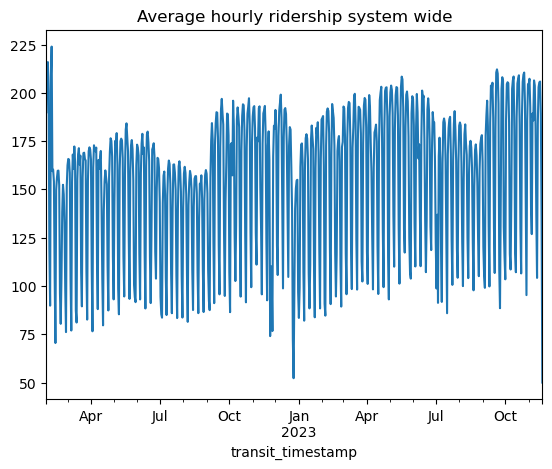

In [7]:
# Analyze dataset for overall ridership trends, average for each station, and compare select stations
print(df_url.iloc[0]['transit_timestamp'])
print(df_url.iloc[-1]['transit_timestamp'])
# Group by day and aggregate values (sum, mean, etc.)
daily_data = df_url.groupby(pd.Grouper(key='transit_timestamp',freq='D')).sum()
df_url.groupby(df_url['transit_timestamp'].dt.floor('1D'))["ridership"].mean().dropna().plot(kind="line", title="Average hourly ridership system wide")

As seen above, the ridership varies day by day, but does seem to follow some trends overall. This may make it possible for linear regression to draw a line. Furthermore, as seen below, individual stations can be more static or easier to predict.

117577
657
10


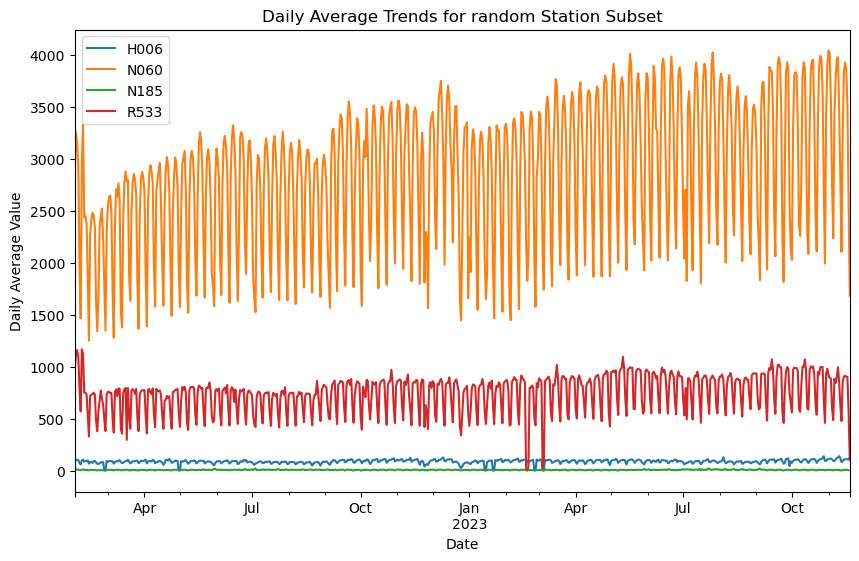

In [8]:
grouped_data = df_url[df_url['station_complex_id'].isin([ 'N060','N185','R533','H006'])]
print(len(grouped_data))
grouped_data=grouped_data.groupby(['station_complex_id', pd.Grouper(key='transit_timestamp', freq='D')])['ridership'].mean().reset_index()

# Pivot the data for easier plotting
pivot_data = grouped_data.pivot(index='transit_timestamp', columns='station_complex_id', values='ridership')
tester=type(pivot_data)
print(len(pivot_data))
subset=pd.concat([pivot_data.iloc[:5],pivot_data.iloc[-5:]],ignore_index=True)
print(len(subset))
# Plot average trends for each group
pivot_data.plot(figsize=(10, 6), title='Daily Average Trends for random Station Subset')

plt.xlabel('Date')
plt.ylabel('Daily Average Value')
plt.legend(title='Group')
plt.legend().set_visible(True)
plt.show()

In [9]:
# Check if Boro, station_id, and station_complex matter for the sake of the data
numStatID=len(df_url['station_complex_id'].unique())
numStat=len(df_url['station_complex'].unique())
numRoutes=len(df_url['routes'].unique())
print(f'Rows: {len(df_url)}, Number of Unique Station IDs: {numStatID} Number of Unique Complexes: {numStat} Number of Unique Routes: {numRoutes}')
print(df_url.dtypes)
# Unique station ID
unique_Complex= df_url.drop_duplicates(subset=['station_complex_id'])
uni_Comp=unique_Complex[['station_complex_id']].to_records(index=False).tolist()
unique_Complex_R= df_url.drop_duplicates(subset=['station_complex_id','routes'])
print(unique_Complex_R['station_complex_id'].value_counts())
uni_Comp_R=unique_Complex_R[['station_complex_id','routes']].to_records(index=False).tolist()
print(len(uni_Comp_R))
unique_Complex_Route= df_url.drop_duplicates(subset=['station_complex_id', 'station_complex'])
uni_Comp_Route=unique_Complex_Route[['station_complex_id', 'station_complex']].to_records(index=False).tolist()
print(uni_Comp_Route[1])
unique_Complex_Station_Borough=df_url.drop_duplicates(subset=['station_complex_id', 'station_complex','borough'])
uni_Comp_Route_Boro=unique_Complex_Station_Borough[['station_complex_id', 'station_complex','borough']].to_records(index=False).tolist()
#print((uni_Comp_Route_Boro))

# compare the two lists to make sure they are the same

print(len(unique_Complex_Route))

print(f'Complex IDs with >1 route {unique_Complex_R["station_complex_id"].value_counts()>1}')
print(uni_Comp_R[uni_Comp_R=="S102" ])
print(f'Number of anamolous SIR pairs {len(df_url[(df_url["station_complex_id"]=="S102") & (df_url["routes"]!="SIR")])}')
print(len(unique_Complex_Station_Borough))
badCount=0
goodCount=0
for i in range(0,425):
    comp_R_tup=uni_Comp_R[i]
    comp_tuple=tuple(uni_Comp[i])
    comp_route_tuple=tuple(uni_Comp_Route[i])
    comp_route_boro_tuple=tuple(uni_Comp_Route_Boro[i][0:2])
    if comp_route_tuple[0] !=comp_R_tup[0]:
        badCount+=1
        
    elif (comp_route_tuple !=comp_route_boro_tuple) or comp_route_tuple[0] != comp_tuple[0]:
        badCount+=1
    else:
        goodCount+=1
print(f'Number of Matches for complex id and complex name: {goodCount}, Number of No Matches: {badCount}')

Rows: 12744121, Number of Unique Station IDs: 425 Number of Unique Complexes: 425 Number of Unique Routes: 94
transit_timestamp     datetime64[ns]
station_complex_id            object
station_complex               object
borough                       object
routes                        object
payment_method                object
ridership                      int64
transfers                      int64
latitude                     float64
longitude                    float64
Georeference                  object
itsuid                        object
Year                           int64
Month                          int64
Day                            int64
Hour                           int64
dtype: object
S102    2
N602    1
R106    1
N046    1
R252    1
       ..
A069    1
J001    1
N532    1
B017    1
R600    1
Name: station_complex_id, Length: 425, dtype: int64
426
('R293', 'Mosholu Pkwy (4)')
425
Complex IDs with >1 route S102     True
N602    False
R106    False
N046    False
R25

In [10]:
# Remove NaN numbers for SIR
print(len(df_url))
df_url=df_url.drop(df_url[(df_url["station_complex_id"]=="S102") & (df_url["routes"]!="SIR")].index)
print(len(df_url))

12744121
12744119


## Create Train and Test sets

As stated above, a training data subset was created using data from June 2023 to Nov 19 2023. The last week (Nov 12-19) was seperated out as a test. 

As seen above, the ridership varies day by day, but does seem to follow some trends overall. This may make it possible for linear regression to draw a line. Furthermore, individual stations vary wildy from each other, but can be more static or easier to predict on their own. 

I also selected a station, R533 Flusing Main Street for my models to test on, both within the subset and on the data as a whole.

In [12]:
# Remove data one week out from training and set an index
from datetime import timedelta
data_train=df_url.sort_values(by=['transit_timestamp']).set_index('transit_timestamp')
data_train=data_train.drop(columns=['Georeference', 'itsuid','latitude','longitude','transfers','borough','station_complex'])
data_train=pd.get_dummies(data_train)
print(data_train.dtypes)
print(len(data_train))
lastDate=(df_url['transit_timestamp'].max()- timedelta(days=7)).strftime("%Y-%m-%d")
lastWeek=len(df_url[df_url['transit_timestamp']>lastDate])

dtrain=data_train[data_train.index>'2023-06-01'][:-lastWeek]
dtest=data_train[data_train.index>'2023-06-01'][-lastWeek:]

ridership                   int64
Year                        int64
Month                       int64
Day                         int64
Hour                        int64
                            ...  
routes_S                    uint8
routes_S,A                  uint8
routes_SIR                  uint8
payment_method_metrocard    uint8
payment_method_omny         uint8
Length: 525, dtype: object
12744119


In [54]:
lastDate2=(df_url[df_url['station_complex_id']=='R533']['transit_timestamp'].max()- timedelta(days=7)).strftime("%Y-%m-%d")
lastweekData=len(data_train[(data_train.index>lastDate2)& (data_train['station_complex_id_R533']==1)])
print(lastDate2)
print(lastweekData)
dtrain_R533_subset=data_train[(data_train.index>'2023-06-01')& (data_train['station_complex_id_R533']==1)][:-lastweekData]
dtest_R533_subset=data_train[(data_train.index>'2023-06-01')& (data_train['station_complex_id_R533']==1)][-lastweekData:]

dtrain_R533=data_train[data_train['station_complex_id_R533']==1][:-lastweekData]
dtest_R533=data_train[data_train['station_complex_id_R533']==1][-lastweekData:]

2023-11-12
336


# Training on Last 6 Months of Data and Subset

## Training skforecast ForecasterAutoreg

For the ForecastAutoRegressor, I trained it on the entire subset at once, for a specific station in the subset, and then for a specific station using the whole dataset.

In [72]:
# Train over last 6 months of data for all
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123,
n_estimators=10,max_depth=18),
                 lags      = 1
             )

forecaster.fit(y=dtrain['ridership'])
forecaster


C:\Users\bmurp\anaconda3\Lib\site-packages\skforecast\utils\utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
C:\Users\bmurp\anaconda3\Lib\site-packages\skforecast\utils\utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=18, n_estimators=10, random_state=123) 
Lags: [1] 
Transformer for y: None 
Transformer for exog: None 
Window size: 1 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 3213149] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 18, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-12-17 23:17:37 
Last fit date: 2023-12-17 23:17:49 
Skforecast version: 0.11.0 
Python version: 3.11.3 
Forecaster id: None 

In [73]:
# Generate next week of predictions
steps=lastWeek
print(steps)
predictions_all = forecaster.predict(steps=steps)

136921


C:\Users\bmurp\anaconda3\Lib\site-packages\skforecast\utils\utils.py:867: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


float64
<class 'dict'>
1000


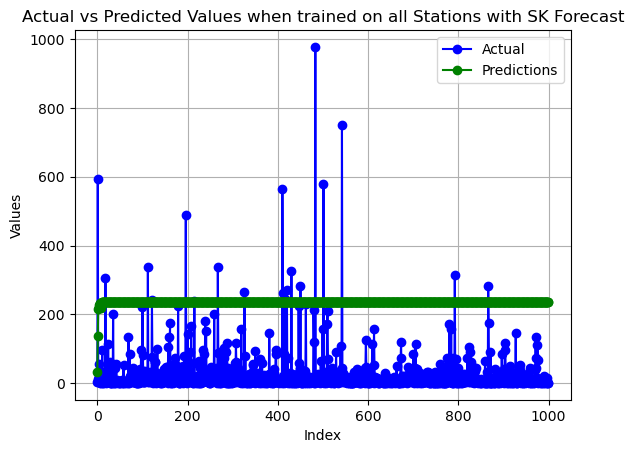

In [74]:
print(predictions.dtypes)
Pred_vs_Actual={
    "Predictions":list(predictions_all.iloc[:1000]),
    "Actual": list(dtest.iloc[:1000]['ridership'])
}
print(type(Pred_vs_Actual))
print(len(Pred_vs_Actual["Actual"]))
df=pd.DataFrame(dict(list(Pred_vs_Actual.items())))
df=pd.DataFrame(Pred_vs_Actual)
df=df[:1000]
plt.plot(df['Actual'], label='Actual', marker='o', linestyle='-', color='blue')
plt.plot(df['Predictions'], label='Predictions', marker='o', linestyle='-', color='green')
plt.title('Actual vs Predicted Values when trained on all Stations with SK Forecast')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

In [75]:
# Train over last 6 months of data for one station
forecaster_R533_Subset = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123,
n_estimators=10,max_depth=18),
                 lags      = 1
             )
forecaster_R533_Subset.fit(y=dtrain_R533_subset['ridership'])
forecaster_R533_Subset

C:\Users\bmurp\anaconda3\Lib\site-packages\skforecast\utils\utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
C:\Users\bmurp\anaconda3\Lib\site-packages\skforecast\utils\utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=18, n_estimators=10, random_state=123) 
Lags: [1] 
Transformer for y: None 
Transformer for exog: None 
Window size: 1 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 7844] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 18, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-12-17 23:18:46 
Last fit date: 2023-12-17 23:18:46 
Skforecast version: 0.11.0 
Python version: 3.11.3 
Forecaster id: None 

In [76]:
# Generate next week of predictions
steps=lastweekData
print(steps)
predictions_R533s = forecaster_R533_Subset.predict(steps=steps)

336


C:\Users\bmurp\anaconda3\Lib\site-packages\skforecast\utils\utils.py:867: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


float64


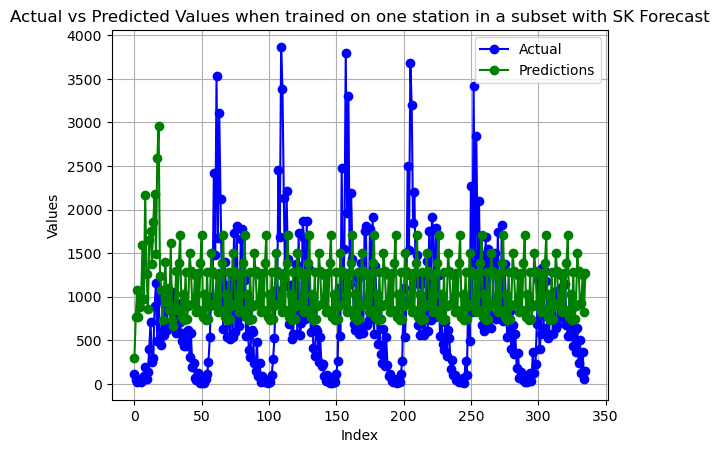

7845


In [77]:
print(predictions.dtypes)
Pred_vs_Actual={
    "Predictions":list(predictions_R533s.iloc[:336]),
    "Actual": list(dtest_R533_subset.iloc[:336]['ridership'])
}
df=pd.DataFrame(dict(list(Pred_vs_Actual.items())))
df=pd.DataFrame(Pred_vs_Actual)
df=df[:1000]
plt.plot(df['Actual'], label='Actual', marker='o', linestyle='-', color='blue')
plt.plot(df['Predictions'], label='Predictions', marker='o', linestyle='-', color='green')
plt.title('Actual vs Predicted Values when trained on one station in a subset with SK Forecast')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()
print(len(dtrain_R533_subset))

336


C:\Users\bmurp\anaconda3\Lib\site-packages\skforecast\utils\utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
C:\Users\bmurp\anaconda3\Lib\site-packages\skforecast\utils\utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
C:\Users\bmurp\anaconda3\Lib\site-packages\skforecast\utils\utils.py:867: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


float64


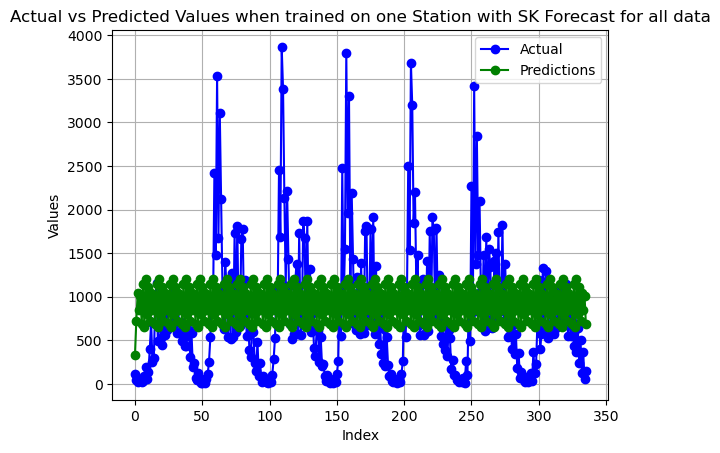

30701


In [78]:
# Train over last 6 months of data for one station
forecaster_R533 = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123,
n_estimators=10,max_depth=18),
                 lags      = 1
             )
forecaster_R533.fit(y=dtrain_R533['ridership'])
forecaster_R533
# Generate next week of predictions
steps=lastweekData
print(steps)
predictions_R533 = forecaster_R533.predict(steps=steps)
print(predictions.dtypes)
Pred_vs_Actual={
    "Predictions":list(predictions_R533.iloc[:336]),
    "Actual": list(dtest_R533.iloc[:336]['ridership'])
}
df=pd.DataFrame(dict(list(Pred_vs_Actual.items())))
df=pd.DataFrame(Pred_vs_Actual)
df=df[:1000]
plt.plot(df['Actual'], label='Actual', marker='o', linestyle='-', color='blue')
plt.plot(df['Predictions'], label='Predictions', marker='o', linestyle='-', color='green')
plt.title('Actual vs Predicted Values when trained on one Station with SK Forecast for all data')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()
print(len(dtrain_R533))

## Linear Regression Training

Since linear regression does not allow for partial fit, I trained Linear Regression on the whole subset and a specific station only on both subset and overall.

In [81]:
from collections import Counter
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
X=dtrain.drop(columns=['ridership'])
y=dtrain['ridership']
model=LinearRegression()
#X['transit_timestamp']=X['transit_timestamp'].values.astype("float64")

print('Training LR on whole subset')
start=time.time()
model.fit(X,y)
stop=time.time()-start
print("Time take to train: "+str(stop))
# acc=model.score(X,y)
print(f' Final model score is {model.score(X,y)}')

Training LR on whole dataset
Time take to train: 100.25553226470947
 Final model score is 0.47369931414555133


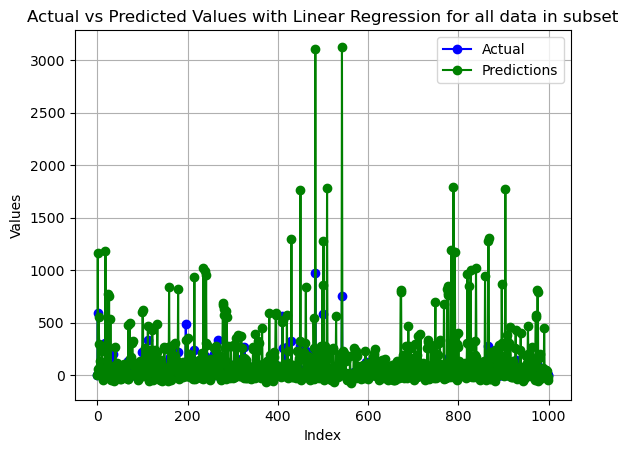

136921


In [98]:
testX=dtest.drop(columns=['ridership'])
testy=dtest['ridership']
pred=model.predict(testX)
Pred_vs_Actual={
    "Predictions":list(pred[:1000]),
    "Actual": list(testy[:1000])
}
df=pd.DataFrame(dict(list(Pred_vs_Actual.items())))
df=pd.DataFrame(Pred_vs_Actual)
df=df[:1000]
plt.plot(df['Actual'], label='Actual', marker='o', linestyle='-', color='blue')
plt.plot(df['Predictions'], label='Predictions', marker='o', linestyle='-', color='green')
plt.title('Actual vs Predicted Values with Linear Regression for all data in subset')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()
print(len(testX))

Training LR on whole subset
Time take to train: 0.15956473350524902
 Final model score is -3.9700643598445895


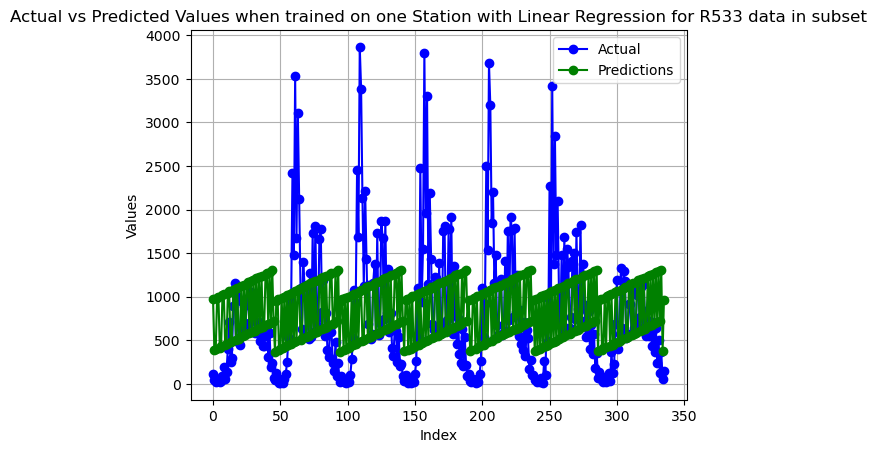

7845


In [97]:
# Train on R533 in subset data
X533s=dtrain_R533_subset.drop(columns=['ridership'])
y533s=dtrain_R533_subset['ridership']
model533s=LinearRegression()
#X['transit_timestamp']=X['transit_timestamp'].values.astype("float64")

print('Training LR on whole subset')
start=time.time()
model533s.fit(X533s,y533s)
stop=time.time()-start
print("Time take to train: "+str(stop))
# acc=model.score(X,y)
print(f' Final model score is {model533s.score(X,y)}')

testX533s=dtest_R533_subset.drop(columns=['ridership'])
testy533s=dtest_R533_subset['ridership']
pred533s=model533s.predict(testX533s)
Pred_vs_Actual={
    "Predictions":list(pred533s[:336]),
    "Actual": list(testy533s[:336])
}
df=pd.DataFrame(dict(list(Pred_vs_Actual.items())))
df=pd.DataFrame(Pred_vs_Actual)
df=df[:1000]
plt.plot(df['Actual'], label='Actual', marker='o', linestyle='-', color='blue')
plt.plot(df['Predictions'], label='Predictions', marker='o', linestyle='-', color='green')
plt.title('Actual vs Predicted Values when trained on one Station with Linear Regression for R533 data in subset')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()
print(len(dtrain_R533_subset))

Training LR on whole subset
Time take to train: 0.5574071407318115
 Final model score is -4.194698789122147


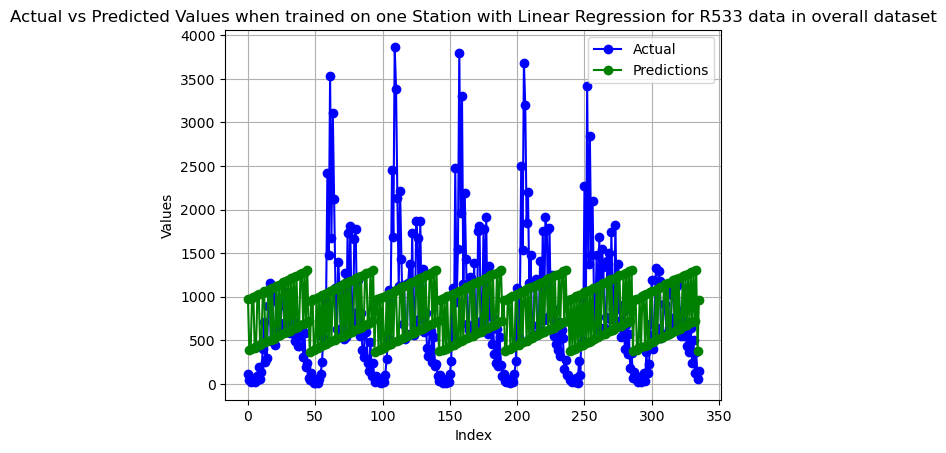

30701


In [96]:
# Train on R533 in subset data
X533=dtrain_R533.drop(columns=['ridership'])
y533=dtrain_R533['ridership']
model533=LinearRegression()
#X['transit_timestamp']=X['transit_timestamp'].values.astype("float64")

print('Training LR on whole subset')
start=time.time()
model533.fit(X533,y533)
stop=time.time()-start
print("Time take to train: "+str(stop))
# acc=model.score(X,y)
print(f' Final model score is {model533.score(X,y)}')

testX533=dtest_R533.drop(columns=['ridership'])
testy533=dtest_R533['ridership']
pred533=model533s.predict(testX533)
Pred_vs_Actual={
    "Predictions":list(pred533[:336]),
    "Actual": list(testy533[:336])
}
df=pd.DataFrame(dict(list(Pred_vs_Actual.items())))
df=pd.DataFrame(Pred_vs_Actual)
df=df[:1000]
plt.plot(df['Actual'], label='Actual', marker='o', linestyle='-', color='blue')
plt.plot(df['Predictions'], label='Predictions', marker='o', linestyle='-', color='green')
plt.title('Actual vs Predicted Values when trained on one Station with Linear Regression for R533 data in overall dataset')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()
print(len(dtrain_R533))